## Aprendizaje no supervisado: Clustering

#### Marcelo Cena

### Objetivos

En este practico se explorar ́an diferentes soluciones de clustering, para desarrollar las capacidades de analisis de
soluciones de clustering. Es preferible que los conjuntos de datos con los que trabajar sean propios, ya que de esta forma podran aplicar su conocimiento del dominio en la interpretacion de las diferentes soluciones. Alternativamente, pueden usar conjuntos de datos de los ejemplos de la materia.

En los mismos, hacer una breve discusion del problema y explicar como puede ser  ́util usar tecnicas de clustering.

In [1]:
from sklearn.datasets import load_files 

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

from __future__ import print_function

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib
from sklearn.cluster import KMeans

# Dataset

Usaremos un dataset extraido de https://labrosa.ee.columbia.edu/millionsong/ que consiste en datos de canciones extraidos de diferentes sitios y el rating que los usuarios le dan a las mismas.
Este dataset contiene dos archivos, uno guardado en formato csv, contiene metadatos de cada canción, como id, título, disco, artista y año, de los cuales vamos a utilizar solamente los datos correspondientes a los titulos y disco para intentar hacer un clustering de las canciones en relación a las palabras en común.

In [2]:
canciones = pd.read_csv('data/song_data.csv')
display(canciones.head(2))
canciones_df = pd.read_table('data/Songs_10000.txt',header=None)
canciones_df.columns = ['user_id', 'song_id', 'listen_count']
display(canciones_df.head(2))


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995


,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2


In [3]:
song_df1 = pd.merge(canciones_df, canciones.drop_duplicates(['song_id']), on="song_id", how="left")

In [4]:
len(song_df1)

2000000

Como ejemplo veamos la primera entrada del dataset:

In [5]:
song_df= song_df1.head(25000)
display(song_df.head(5))

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


Ahora vamos a extraer solamente los datos correspondientes al título,resumen de cada entrada para hacer el clustering y los tags para luego implementar una métrica basada en testigos.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

song_df.groupby('title')['listen_count'].mean().sort_values(ascending=False).head()

title
Times                                    140.0
Waiting For A Dream                      124.0
How Am I Supposed To Live Without You     69.0
We Have A Map Of The Piano                62.0
Quutamo                                   60.0
Name: listen_count, dtype: float64

In [7]:
song_df.groupby('title')['listen_count'].count().sort_values(ascending=False).head()

title
Sehr kosmisch                     97
Dog Days Are Over (Radio Edit)    86
Secrets                           79
Undo                              78
Revelry                           76
Name: listen_count, dtype: int64

In [8]:
ratings = pd.DataFrame(song_df.groupby('title')['listen_count'].mean())
ratings.head()

,listen_count
title,
#40,1.000000
& Down,3.714286
' Cello Song,1.000000
'97 Bonnie & Clyde,1.000000
'Round Midnight,1.000000


In [9]:
ratings['num of ratings'] = pd.DataFrame(song_df.groupby('title')['listen_count'].count())
ratings.head()

,listen_count,num of ratings
title,,
#40,1.000000,1
& Down,3.714286,7
' Cello Song,1.000000,2
'97 Bonnie & Clyde,1.000000,3
'Round Midnight,1.000000,5


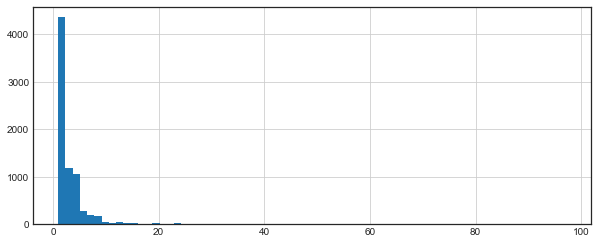

In [10]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

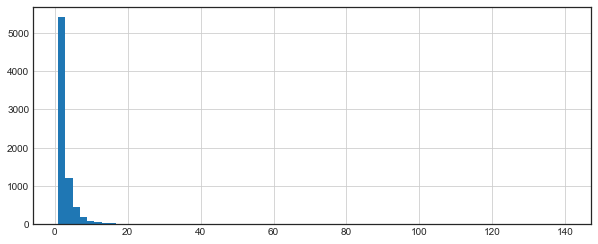

In [11]:
plt.figure(figsize=(10,4))
ratings['listen_count'].hist(bins=70)


C:\Users\marcelo.cena\AppData\Roaming\Python\Python35\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\marcelo.cena\AppData\Roaming\Python\Python35\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


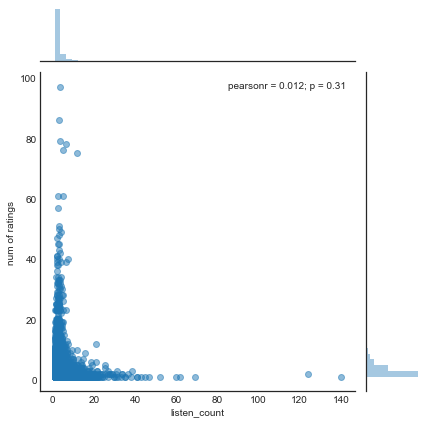

In [12]:
sns.jointplot(x='listen_count',y='num of ratings',data=ratings,alpha=0.5)

In [13]:
titles = [song_df["title"][i] for i in range(len(song_df))]
len(titles)


25000

In [14]:
summaries = [song_df["release"][i] for i in range(len(song_df))]
len(summaries)


25000

In [15]:
authors=[song_df["artist_name"][i] for i in range(len(song_df))]
len(authors)

25000

In [16]:
titles[4760]

'Shut Up'

In [17]:
summaries[4760]

'Hits For Kids 11'

In [18]:
authors[4760]

'Black Eyed Peas'

A continuación definimos un tokenizer para poder aplicar el TfidfVectorizer

In [19]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
         if token[0] not in ["\\","'","-"]:
          if len(token)>2: #eliminar palabras cortas
            filtered_tokens.append(token)
    return filtered_tokens

In [20]:
# e.g.:
from nltk.tokenize import word_tokenize
text = summaries[4760]
print (text)
tokens = tokenize_only(text)
print(tokens)

Hits For Kids 11
['hits', 'for', 'kids']


In [21]:
totalvocab_tokenized = []

for i in summaries:
    if len(i)>1:
        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

In [22]:
print('Hay en total ' + str(len(totalvocab_tokenized)) + ' tokens \n')
len(totalvocab_tokenized)
print (totalvocab_tokenized[0:100])

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_tokenized)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

Hay en total 67791 tokens 

['thicker', 'than', 'water', 'flamenco', 'para', 'niños', 'graduation', 'between', 'dreams', 'there', 'nothing', 'left', 'lose', 'antología', 'audiovisual', 'the', 'fame', 'monster', 'there', 'nothing', 'left', 'lose', 'musik', 'von', 'harmonia', 'hôtel', 'costes', 'stéphane', 'pompougnac', 'had', 'eyes', 'way', 'out', 'original', 'hits', 'rock', 'as/is', 'cleveland/cincinnati_', 'diggin', 'deeper', 'volume', 'incredibad', 'live', 'chicago', 'graduation', 'there', 'nothing', 'left', 'lose', 'fleet', 'foxes', 'sun', 'giant', 'concert', 'noble', 'beast', 'room', 'for', 'squares', 'book', 'like', 'this', 'live', 'malaysia', 'serendipity', 'music', 'from', 'the', 'miramax', 'motion', 'picture', 'where', 'the', 'light', 'john', 'mayer', 'live', 'los', 'angeles', 'bleed', 'american', 'segundos', 'oscuridad', 'the', 'richest', 'man', 'babylon', 'songs', 'you', 'know', 'christmas', 'soul', 'classics', 'nick', 'norah', 'infinite', 'playlist', 'music', 'from', 'the']


Finalmente utilizamos TfidfVectorizer para representar los resumenes npumericamente y poder usar el algoritmo k-means para hacer el clustering.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,strip_accents="unicode", #max_features=400000,
                                 min_df=4, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, 
                                   ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(summaries) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

(25000, 5062)


C:\Users\marcelo.cena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Revisamos los términos extraidos del dataset

In [24]:
terms[200:350]

['art fugue solo',
 'artist',
 'artists/rough',
 'artists/rough trade',
 'artists/rough trade counter',
 'arular',
 'ash',
 'ash digital',
 'ash digital urn',
 'asha',
 'atlantic',
 'atlantic years',
 'atom',
 'atomic',
 'atomic best',
 'atomic best blondie',
 'attack',
 'attack decay',
 'attack decay sustain',
 'attack release',
 'attacks_',
 'attacks_ vol',
 'attic',
 'attitude',
 'audience',
 'audio',
 'audio documents',
 'audio documents volume',
 'audioslave',
 'audiovisual',
 'auditorio',
 'auditorio nacional',
 'aunque',
 'aunque cueste',
 'aunque cueste ver',
 'austin',
 'austin city',
 'austin city limits',
 'australia',
 'australian',
 'australian version',
 'autobiography',
 'avenger',
 'avenger bonus',
 'avenger bonus edition',
 'avenue',
 'avery',
 'avery island',
 'awake',
 'awake america',
 'awake deluxe',
 'awake morning',
 'awakening',
 'awakening special',
 'awakening special edition',
 'awards',
 'away',
 'away original',
 'away original motion',
 "b'day",
 "b'day de

### Métrica basada en testigos

Ahora vamos a evaluar el rendimiento del clustering con k-means para distintos valores de $k$, utilizando la silhouette score, la inercia y la métrica testigo implementada.

In [25]:
from sklearn.metrics import silhouette_score
range_n_clusters=range(2,20,1)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(tfidf_matrix)
    centers = clusterer.cluster_centers_
    clusters = clusterer.labels_.tolist()

    score = silhouette_score(tfidf_matrix, preds, metric='cosine')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    #print("Inertia is {})".clusterer.inertia_)
    testigos(equaltags, clusters)
    for i in range(n_clusters):
     print ('El cluster %i tiene %i elementos' % (i, clusters.count(i)))
    print("=" *40)
#plot it
#fig = plt.figure(figsize=(15, 5))
#plt.plot(range(2, 500, 10), score)
#plt.grid(True)
#plt.title('Elbow curve')

For n_clusters = 2, silhouette score is 0.008618445820480868)


NameError: name 'testigos' is not defined

Text(0.5,1,'Elbow curve')

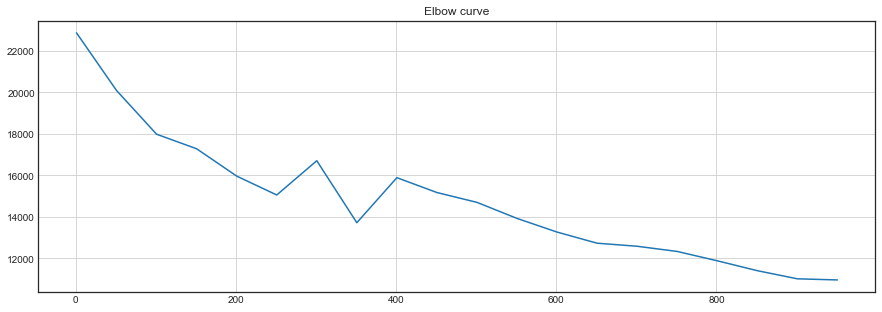

In [26]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 1000, 50):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 1000, 50), wcse)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5,1,'Elbow curve')

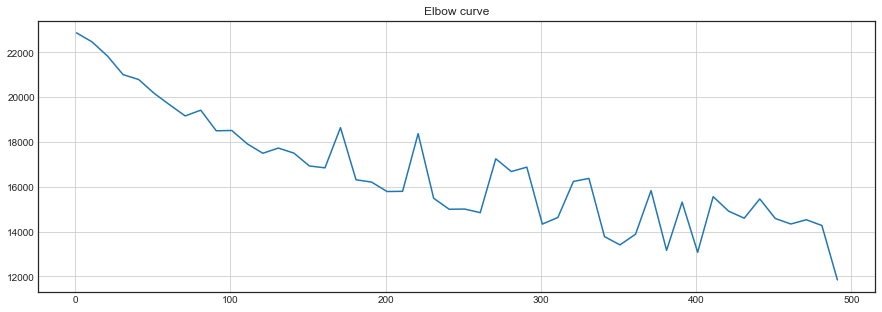

In [27]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 500, 10):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 500, 10), wcse)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5,1,'Elbow curve')

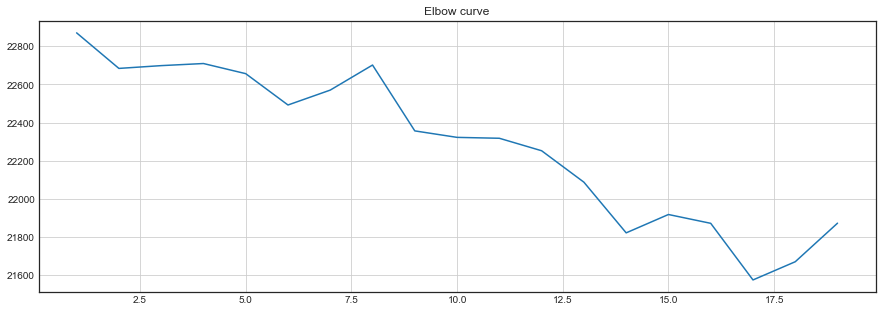

In [28]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 20, 1):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=10000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 20, 1), wcse)
plt.grid(True)
plt.title('Elbow curve')

Si bien ninguna de las métricas nos provee una forma univoca de elegir un número de clusters óptimo, para hacer un análisis mas profundo tomaremos el valor $k=8$.
Adicionalmente, se observa en todos los casos que hay un cluster dominante, enseguida analizaremos la razón, a priori podemos estimar que los nombres de las canciones tiene palabras "GANCHO" que son utilizadas para atraer sobre las mismas atención.

In [29]:
from sklearn.cluster import KMeans

num_clusters = 8

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Vemos la cantidad de elementos en cada cluster

In [30]:
# Recuento del número de elementos en cada cluster
for i in range(num_clusters):
    print ('El cluster %i tiene %i elementos' % (i, clusters.count(i)))

El cluster 0 tiene 348 elementos
El cluster 1 tiene 407 elementos
El cluster 2 tiene 399 elementos
El cluster 3 tiene 370 elementos
El cluster 4 tiene 96 elementos
El cluster 5 tiene 354 elementos
El cluster 6 tiene 22970 elementos
El cluster 7 tiene 56 elementos


In [31]:
abst = { 'title': titles, 'summary': summaries, 'cluster': clusters }
frame = pd.DataFrame(abst, columns = ['title',"cluster"])

In [32]:
frame[1:20]

,title,cluster
1,Entre Dos Aguas,6
2,Stronger,6
3,Constellations,6
4,Learn To Fly,6
5,Apuesta Por El Rock 'N' Roll,6
6,Paper Gangsta,6
7,Stacked Actors,6
8,Sehr kosmisch,6
9,Heaven's gonna burn your eyes,6
10,Let It Be Sung,6


Ahora veremos los términos que determinan cada uno de los clusters para tratar de caracterizarlos

In [33]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]     
        
for i in range(num_clusters):
    print("*** Cluster %d:" % i, end='\n\n')
    
    print("WORDS /// ", end='')
    
    for ind in order_centroids[i, :30]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=' / ')
    print() #add whitespace
    print("=" *100) #add whitespace
    
    #print("TITLES /// ", end='')
    #for title in frame.loc[i]['title'].values.tolist():
    #    print(' %s / ' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()        
        

Top terms per cluster:

*** Cluster 0:

WORDS ///  hits /  greatest /  greatest /  chronicle /  chronicle /  chronicle /  rearviewmirror /  rearviewmirror /  rearviewmirror /  life /  life /  greatest /  hits /  makers /  history /  makers /  makers /  history /  life /  hits /  hits /  greatest /  atlantic /  atlantic /  history /  greatest /  hits /  greatest /  collection /  hits / 


*** Cluster 1:

WORDS ///  live /  vespertine /  vespertine /  world /  live /  chicago /  live /  era /  learn /  learn /  world /  milton /  live /  live /  revolution /  revolution /  keynes /  road /  milton /  road /  revolution /  live /  greek /  live /  greek /  theatre /  road /  lansdowne_ /  live /  live / 


*** Cluster 2:

WORDS ///  music /  motion /  picture /  motion /  music /  music /  picture /  motion /  wild /  music /  juno /  juno /  juno /  music /  music /  sun /  original /  original /  motion /  picture /  lights /  original /  soundtrack /  lights /  state /  state /  garden

A tráves de un wordcloud pueden verse mejor los términos

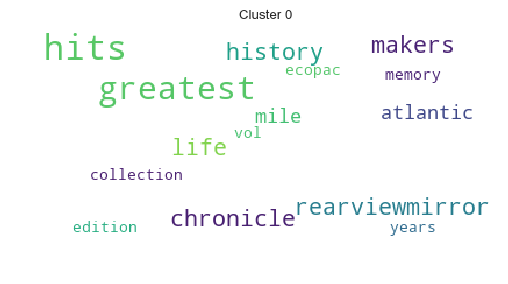

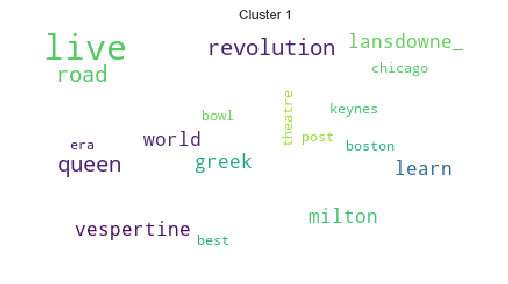

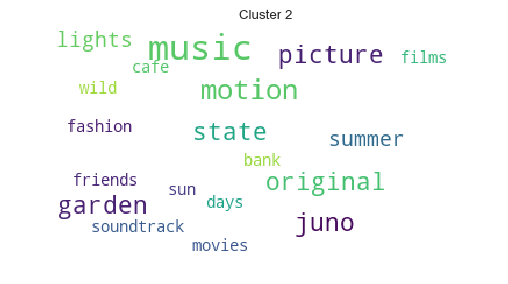

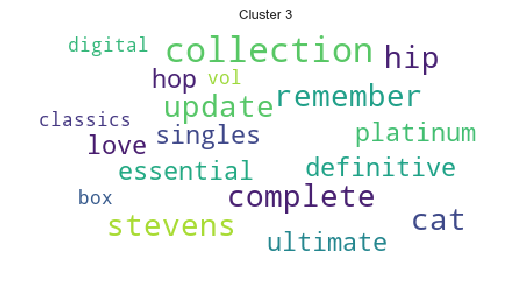

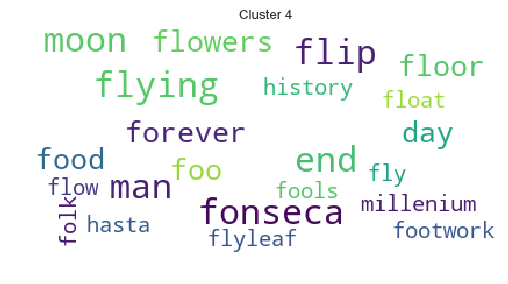

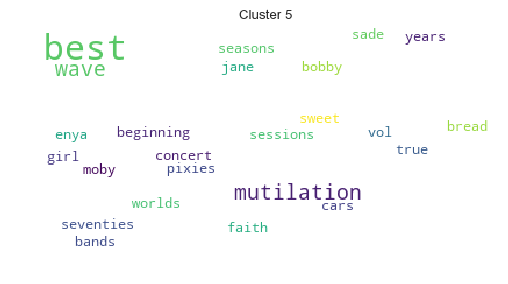

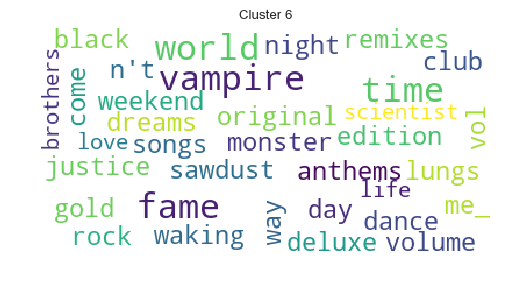

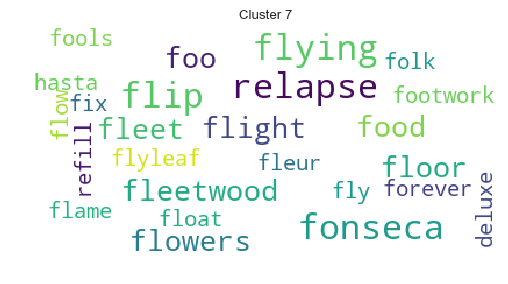

In [34]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(6.0,4.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=8              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

order_centroids = km.cluster_centers_.argsort()[:, ::-1]     
        
for i in range(num_clusters):
 data=""
 for ind in order_centroids[i, :40]:
  data = data + " " + str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=30, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.figure(1)
 plt.title("Cluster %s" %i)
 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


A partir de estos datos y observando los títulos de algunos de los artículos de cada cluster podemos tratar de interpretar cada uno de ellos.

### Cluster 0 

Las palabras principales indican que en este cluster hay más canciones que llevan en su título music, garden, original.

In [35]:
frame[frame["cluster"]==0].sample(10)

,title,cluster
14960,Addicted,0
16589,Down On The Corner,0
7888,Yesterdays,0
16411,Baby Love,0
22569,One More Night,0
13828,Amanda,0
16801,The World's Greatest,0
18062,Sympathy For The Devil,0
18125,Over You,0
20536,Deeper,0


### Cluster 1 
Es el cluster que tiene mas elementos, Parecen ser canciones sobre dance, monster, night.


In [36]:
frame[frame["cluster"]==1].sample(10)

,title,cluster
9057,Kiss Me_ I'm Sh*tfaced,1
15825,SATORI,1
13202,I'll Give All My Love To You (feat. Monica),1
19008,Wish,1
9314,Don't Think I Don't Think About It,1
12834,Behind The Sea [Live In Chicago],1
11609,Who Will Save Your Soul,1
16724,Back In Time (LP Version),1
20853,Rocket Queen,1
18888,Undo,1


### Cluster 2

Es el cluster mas pequeño. El tema central de este cluster parece ser canciones con palabras con F : film, free, flowers ...

In [37]:
frame[frame["cluster"]==2].sample(10)

,title,cluster
20259,Zopf: Pigtail,2
24279,Hey There Delilah,2
23904,Supermassive Black Hole (Twilight Soundtrack Version),2
8676,Dog Days Are Over (Radio Edit),2
2501,You Ain't Seen Nothing Yet,2
21471,Dog Days Are Over (Radio Edit),2
20974,Music Of The Sun,2
16850,Dog Days Are Over (Radio Edit),2
5697,Dog Days Are Over (Radio Edit),2
20312,Dog Days Are Over (Radio Edit),2


### Cluster 3

Este cluster no parece tan fácil de interpretar, entre las palabras principales no hay ninguna que permita distinguir el tópico. Se observan palabras como love, free, good, dream ...

In [38]:
frame[frame["cluster"]==3].sample(10)

,title,cluster
15410,Rehab,3
9463,Epiphany (LP Version),3
9853,Don't Speak,3
8932,Touch My Body,3
5061,I'm Every Woman,3
7900,Hitsville U.K.,3
9776,The Sun Ain't Gonna Shine Anymore,3
10499,Fire,3
12279,Moonshadow,3
7550,Never Before,3


### Cluster 4
 Este cluster parece agrupar canciones que hablan sobre live/life, sunny, best ....


In [39]:
frame[frame["cluster"]==4].sample(10)

,title,cluster
12604,Canada,4
14564,Up Up & Away,4
9563,Canada,4
6193,Up Up & Away,4
18242,Simple As...,4
22220,Canada,4
13562,Sky Might Fall,4
3858,Clampdown,4
12275,My World,4
12353,Solo Dolo (nightmare),4


### Cluster 5

En este cluster se distinguen términos relacionados a great, hit y similares

In [40]:
frame[frame["cluster"]==5].sample(10)

,title,cluster
1390,Nothing Can Come Between Us,5
14208,May It Be (Album version),5
20273,Keep Holding On,5
17923,Ready For The Floor (Album Version),5
24625,For What It's Worth,5
19451,You've Lost That Lovin' Feelin',5
18506,Why Does My Heart Feel So Bad? (2006 Digital Remaster),5
17064,Black And White,5
22880,Hey,5
15197,I'm So Excited,5


### Cluster 6

Este cluster parece estar relacionado con cosas lindas: deluxe, spetial, hemestick ...

In [41]:
frame[frame["cluster"]==6].sample(10)

,title,cluster
12736,Hiding,6
20592,I'll Write A Song For You,6
13532,Ain't Misbehavin,6
2728,Till Dans Med Karlstadtoserna,6
15537,Release Me,6
7602,Change Clothes,6
24292,Going Bad,6
23984,The Lengths,6
3729,Yellow,6
4208,Hello,6


### Cluster 7
 Parecen ser canciones que hablan sobre personas, principalmente por que las palabras "people" y "whatcha" aparecen como algunas de las palabras del cluster.

In [42]:
frame[frame["cluster"]==7].sample(10)

,title,cluster
4575,Same Song & Dance,7
21090,Forever,7
13075,Hell Breaks Loose,7
6187,Forever,7
14080,Same Song & Dance,7
1285,Forever,7
10265,Forever,7
20460,Forever,7
20742,Buffalo Bill,7
20821,Forever,7


## Medoids

El metodo k-means de scikit-learn no provee una forma sencilla de obtneer los objetos mas cercanos al centroide
de un cluster.
A continuación trataremos de encontrar los elementos del dataset que esten más ceca de cada uno de los clusters etc. En lo posible, implementarlos y
mostrar esos elementos, discutir la representatividad de los elementos encontrados.

In [43]:
from sklearn.metrics import pairwise_distances_argmin
closest= pairwise_distances_argmin(km.cluster_centers_, tfidf_matrix,metric="cosine")

In [44]:
closest

array([1076,  252,   89,  646,  570,   61,  176, 1285], dtype=int64)

In [45]:
for x in closest:
 print("=" *60)
 print("Cluster %d" %list(closest).index(x),",",x,titles[x])
 print("-" *60)
 print(summaries[x])


Cluster 0 , 1076 Lost In Love
------------------------------------------------------------
Greatest Hits
Cluster 1 , 252 Poster Of A Girl
------------------------------------------------------------
Live It Out
Cluster 2 , 89 Dog Days Are Over (Radio Edit)
------------------------------------------------------------
Now That's What I Call Music! 75
Cluster 3 , 646 Deep Inside Of You (2006 Remastered LP Version)
------------------------------------------------------------
A Collection
Cluster 4 , 570 Clampdown
------------------------------------------------------------
The End Has No End
Cluster 5 , 61 Besame Mucho
------------------------------------------------------------
The Best of Andrea Bocelli - 'Vivere'
Cluster 6 , 176 Don't Worry 'Bout Me
------------------------------------------------------------
Julie / Love On The Rocks
Cluster 7 , 1285 Forever
------------------------------------------------------------
Relapse: Refill


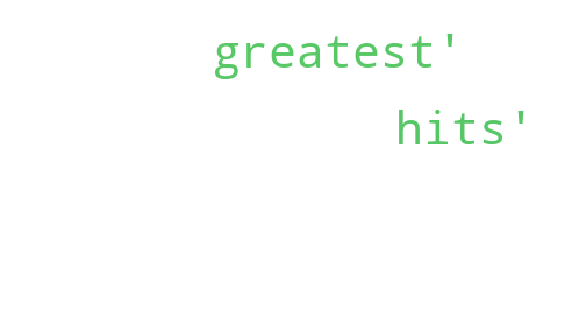

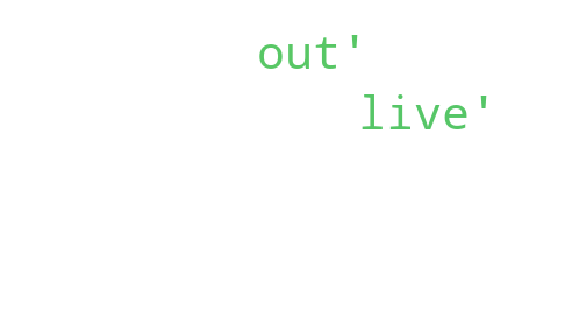

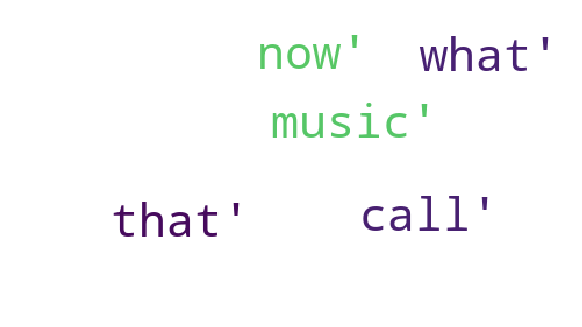

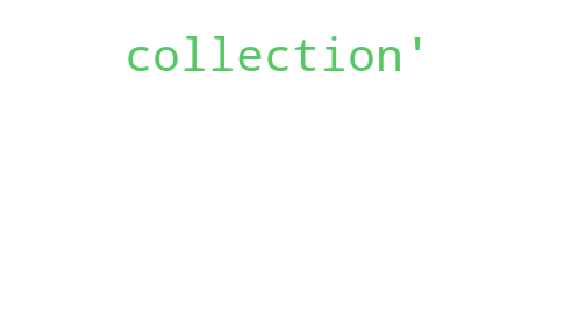

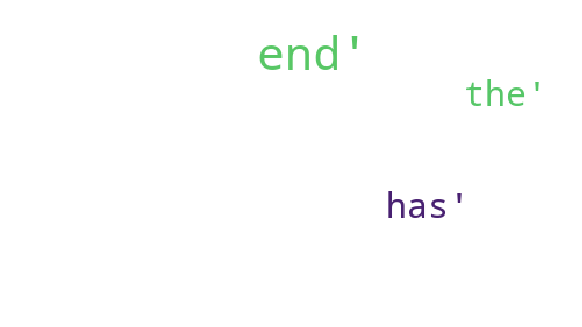

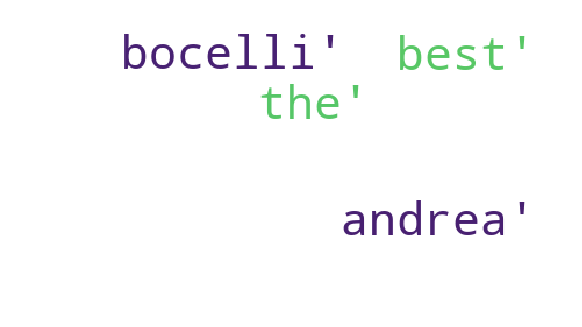

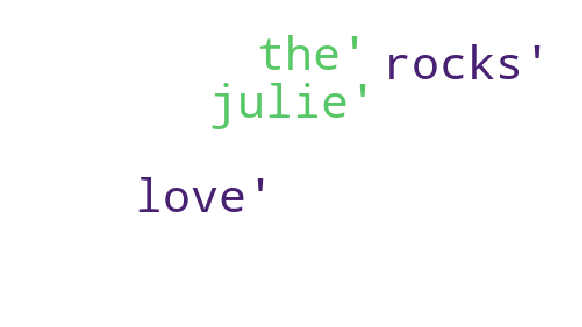

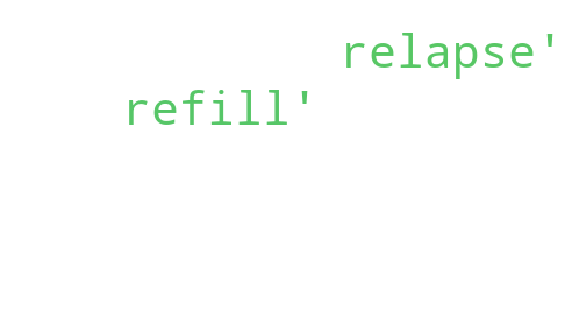

In [46]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(6.0,6.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=40              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

for x in closest:
#stopwords = set(STOPWORDS)
 data = tokenize_only(summaries[x])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.figure(1)
 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


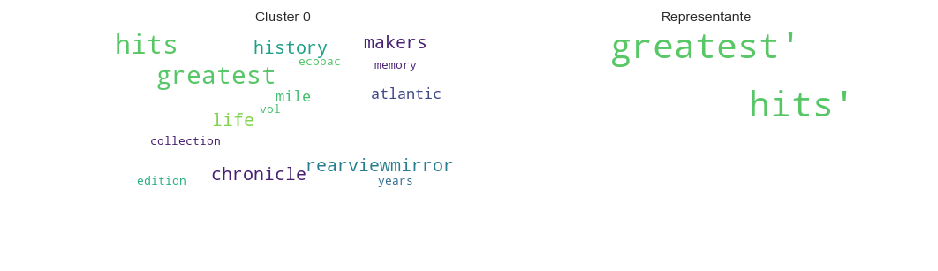

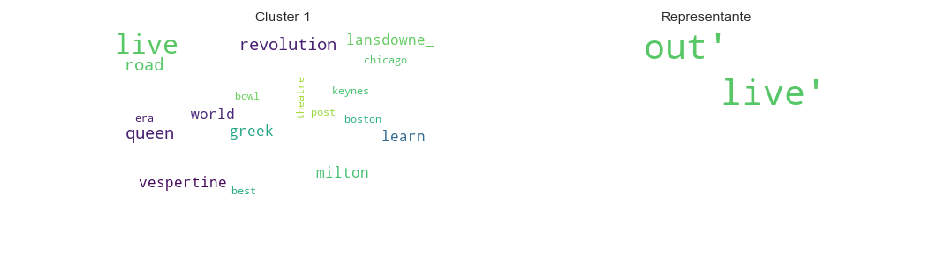

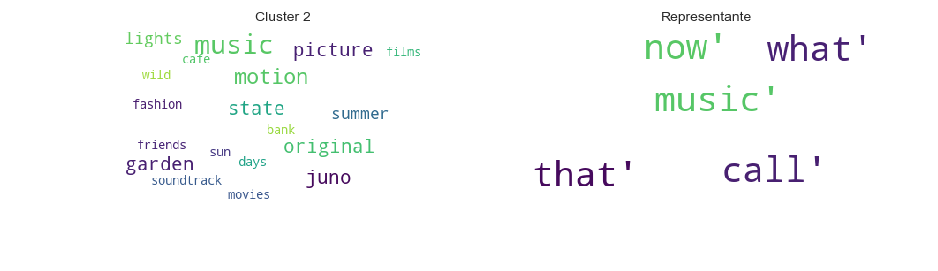

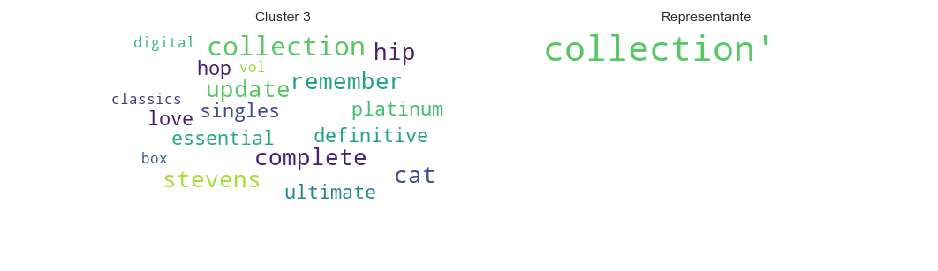

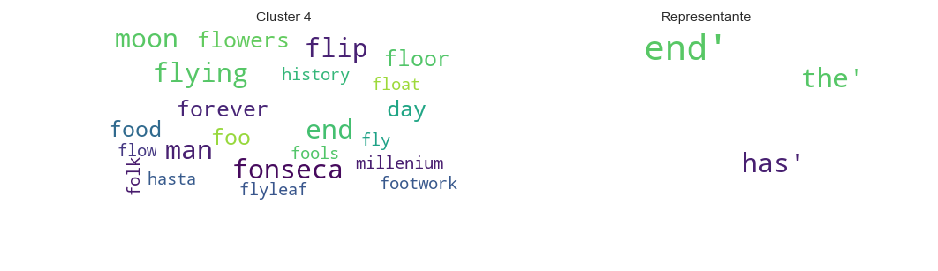

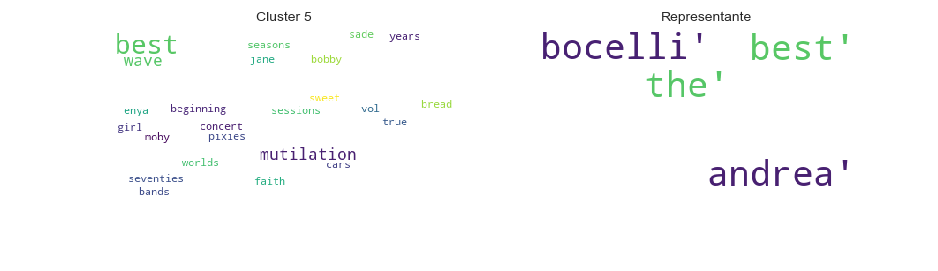

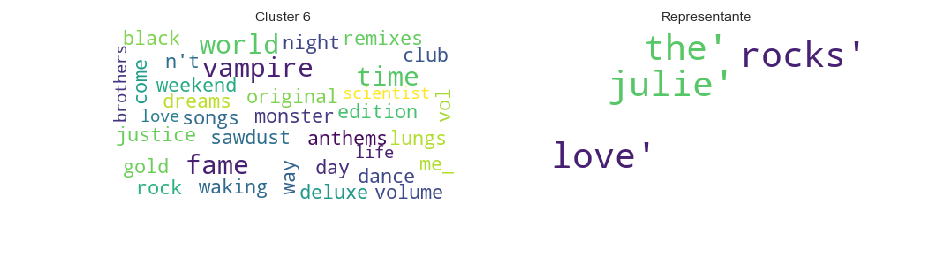

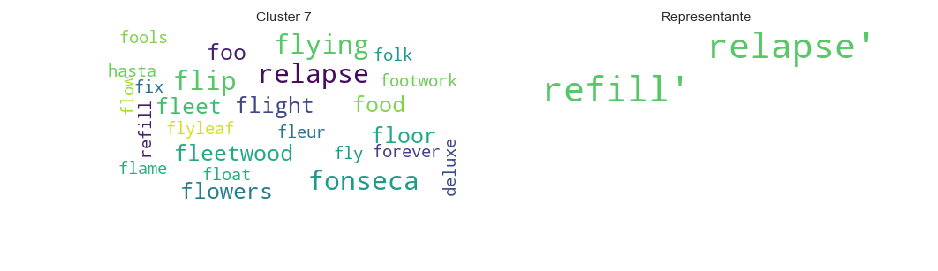

In [47]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=40              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

for i in range(num_clusters):


 data=""
 for ind in order_centroids[i, :40]:
  data = data + " " + str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=30, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.subplot(1, 2, 1)
 plt.title("Cluster %s" %i,fontsize=10)
 plt.imshow(wordcloud)
 plt.axis('off')
    
 x=closest[i]
 data = tokenize_only(summaries[x])

 wordcloud = WordCloud(
                          background_color='white',
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.subplot(1, 2, 2)
 plt.title("Representante",fontsize=10)
 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


Como podemos ver, en la mayoria de los casos las canciones mas cercanas al centroide parecen ser buenos representantes de los clusters.